<a href="https://colab.research.google.com/github/hye0-n0/hye0-n0/blob/main/%5Bkagle%5DCNN_dog_or_cat_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 캐글에서 데이터 불러오기
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 99% 803M/812M [00:04<00:00, 234MB/s]
100% 812M/812M [00:04<00:00, 182MB/s]


In [ ]:
!unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
!unzip test1.zip

In [ ]:
!unzip train.zip

# Import Library

In [ ]:
# 라이브러리
import numpy as np
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator,load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# Define Constants

In [ ]:
# 이미지 속성 지정
image_width = 128
image_height = 128
image_size = (image_width, image_height)
image_channel = 3

# Prepare Traning Data

In [ ]:
filenames = os.listdir("./train")
categories = []
for f_name in filenames:
  category = f_name.split('.')[0]
  if category == 'dog':
    categories.append(1)
  else:
    categories.append(0)

df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [ ]:
df.head()

,filename,category
0,dog.7142.jpg,1
1,cat.8767.jpg,0
2,cat.4644.jpg,0
3,dog.5964.jpg,1
4,cat.1916.jpg,0


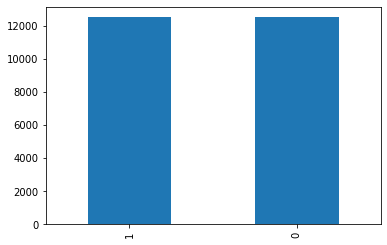

In [ ]:
df['category'].value_counts().plot.bar()

## See sample image

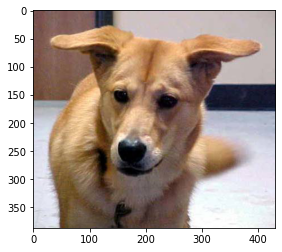

In [ ]:
# 샘플 보기
sample = random.choice(filenames)
image = load_img("./train/"+sample)
plt.imshow(image)

# CNN model
![image](https://i.imgur.com/ebkMGGu.jpg)

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer.

## CNN 모델 구조 생성

In [ ]:
# 모델 생성
import tensorflow as tf

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), 
                                 strides=(1, 1), activation='relu',
                                 input_shape=(image_width,image_height,image_channel), 
                                 name='conv_1'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_1'))
model.add(tf.keras.layers.Dropout(0.25))

In [ ]:
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), 
                                 strides=(1, 1), activation='relu',
                                 input_shape=(image_width,image_height,image_channel), 
                                 name='conv_2'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))
model.add(tf.keras.layers.Dropout(0.25))

In [ ]:
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), 
                                 strides=(1, 1), activation='relu',
                                 input_shape=(image_width,image_height,image_channel), 
                                 name='conv_3'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_3'))
model.add(tf.keras.layers.Dropout(0.25))

In [ ]:
model.add(tf.keras.layers.Flatten())

In [ ]:
model.add(tf.keras.layers.Dense(units=512, name='fc_1', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))

In [ ]:
model.add(tf.keras.layers.Dense(units=2, name='fc_2', activation='softmax'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.build(input_shape=(None,image_width,image_height,image_channel))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 pool_1 (MaxPooling2D)       (None, 63, 63, 32)        0         
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       256       
 hNormalization)                                        

## Callbacks

In [ ]:
# 콜백(과대적합 방지, 성능 개선)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# 10번 학습 후, 검증 손실이 감소하지 않으면 중단
earlystop = EarlyStopping(patience=10)

# 2 step 동안 검증 정확도가 향상되지 않으면 학습 속도(학습률)를 감소
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

## Prepare data

In [ ]:
# 데이터 준비
df['category'] = df['category'].replace({0:'cat', 1:'dog'})

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
train_df.head()

,filename,category
23311,cat.11942.jpg,cat
23623,cat.1922.jpg,cat
1020,cat.283.jpg,cat
12645,dog.2774.jpg,dog
1533,cat.7564.jpg,cat


In [ ]:
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

In [ ]:
tol_train = train_df.shape[0]
tol_valid = valid_df.shape[0]
batch_size=15

### Traning Generator

In [ ]:
# 학습 => 텐서 이미지 데이터 배치를 생성
train_datagen = ImageDataGenerator(rotation_range=15, 
                               rescale=1/255, shear_range=0.1, 
                               zoom_range=0.2, 
                               horizontal_flip=True,
                               width_shift_range=0.1, 
                               height_shift_range=0.1)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(train_df, './train/', 
                                                    x_col='filename', y_col='category', 
                                                    target_size=image_size,
                                                    class_mode='categorical',
                                                    batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
valid_dategen = ImageDataGenerator(rescale=1/255)

In [ ]:
vaild_generator = valid_dategen.flow_from_dataframe(valid_df, './train/', 
                                                    x_col='filename', y_col='category', 
                                                    target_size=image_size,
                                                    class_mode='categorical',
                                                    batch_size=batch_size)

Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
# 생성한 제너레이터 보기
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=image_size,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


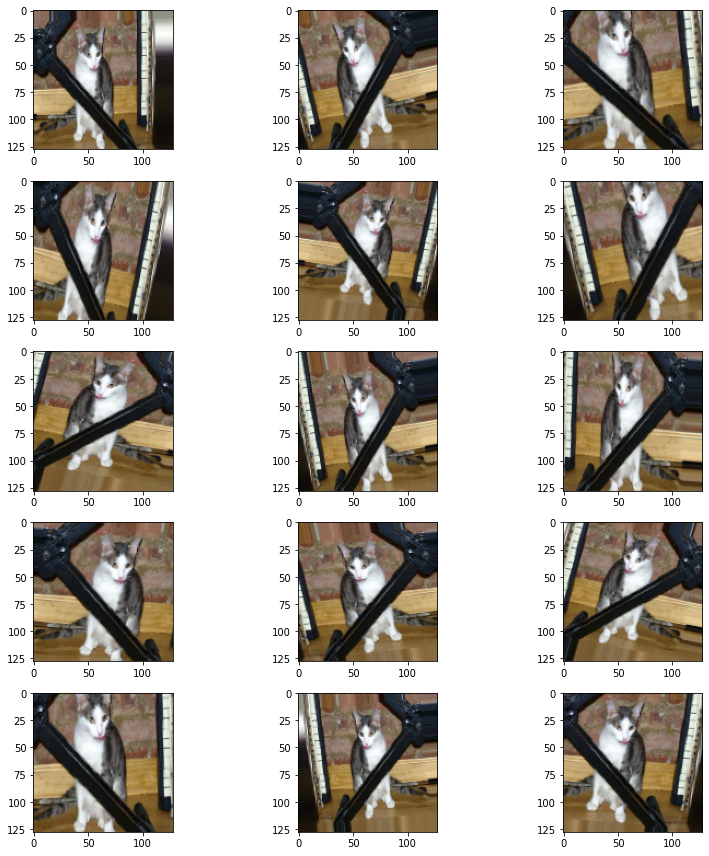

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(15):
  plt.subplot(5, 3, i+1)
  for X_batch, Y_batch in example_generator:
    image = X_batch[0]
    plt.imshow(image)
    break
plt.tight_layout()
plt.show()

# Fit Model
모델 적합

In [ ]:
# 모델 적합
epochs = 3
history = model.fit(train_generator, epochs=epochs, 
                              validation_data=vaild_generator,
                              validation_steps=tol_valid//batch_size,
                              callbacks=callbacks)

Epoch 1/3
1334/1334 [==============================] - 1166s 874ms/step - loss: 0.4688 - accuracy: 0.7835 - val_loss: 0.6628 - val_accuracy: 0.7508 - lr: 0.0010
Epoch 2/3
1334/1334 [==============================] - 1150s 862ms/step - loss: 0.4409 - accuracy: 0.8001 - val_loss: 0.4958 - val_accuracy: 0.8058 - lr: 0.0010
Epoch 3/3
1334/1334 [==============================] - 1153s 865ms/step - loss: 0.4145 - accuracy: 0.8134 - val_loss: 0.4577 - val_accuracy: 0.7868 - lr: 0.0010


## Save Model

In [ ]:
model.save_weights("model.cnn_cat&dog")

## 학습 곡선

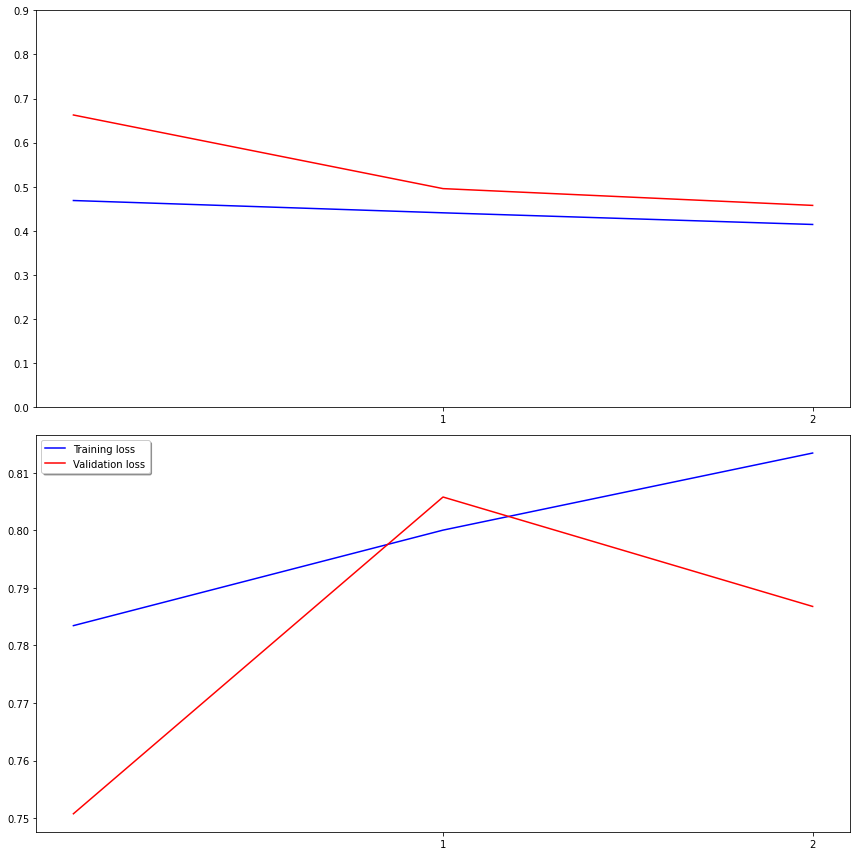

In [ ]:
# 검증학습곡선
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label='Training loss')
ax1.plot(history.history['val_loss'], color='r', label='Vaildation loss')

ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label='Training loss')
ax2.plot(history.history['val_accuracy'], color='r', label='Validation loss')

ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Prepare Testing Data


In [ ]:
# 테스트 셋
test_filenames = os.listdir('./test1')
test_df = pd.DataFrame({'filename':test_filenames})
nb_samples = test_df.shape[0]

### Create Testing Generator

In [ ]:
test_gen = ImageDataGenerator(rescale=1/255)
test_generator = test_gen.flow_from_dataframe(test_df, './test1/', 
                                              x_col='filename', y_col=None, 
                                              target_size=image_size,
                                              class_mode=None,
                                              batch_size=batch_size,
                                              shuffle=False)

Found 12500 validated image filenames.


# Predict

In [ ]:
# 예측
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-55-3723e44f353b>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [ ]:
# Softmax를 통해 나온 결과 중(행 축을 따라) 최대값의 인덱스
test_df['category'] = np.argmax(predict, axis=1)

In [ ]:
# 예측 결과를 훈련셋을 이용해 범주를 변환. 즉 인덱스를 고양이, 개로 변환
label_map = dict((v,k) for k, v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [ ]:
# 다시 고양이와 개를 0, 1로 변환
# test_df['category'] = test_df['category'].replace({'dog':1, 'cat':0})

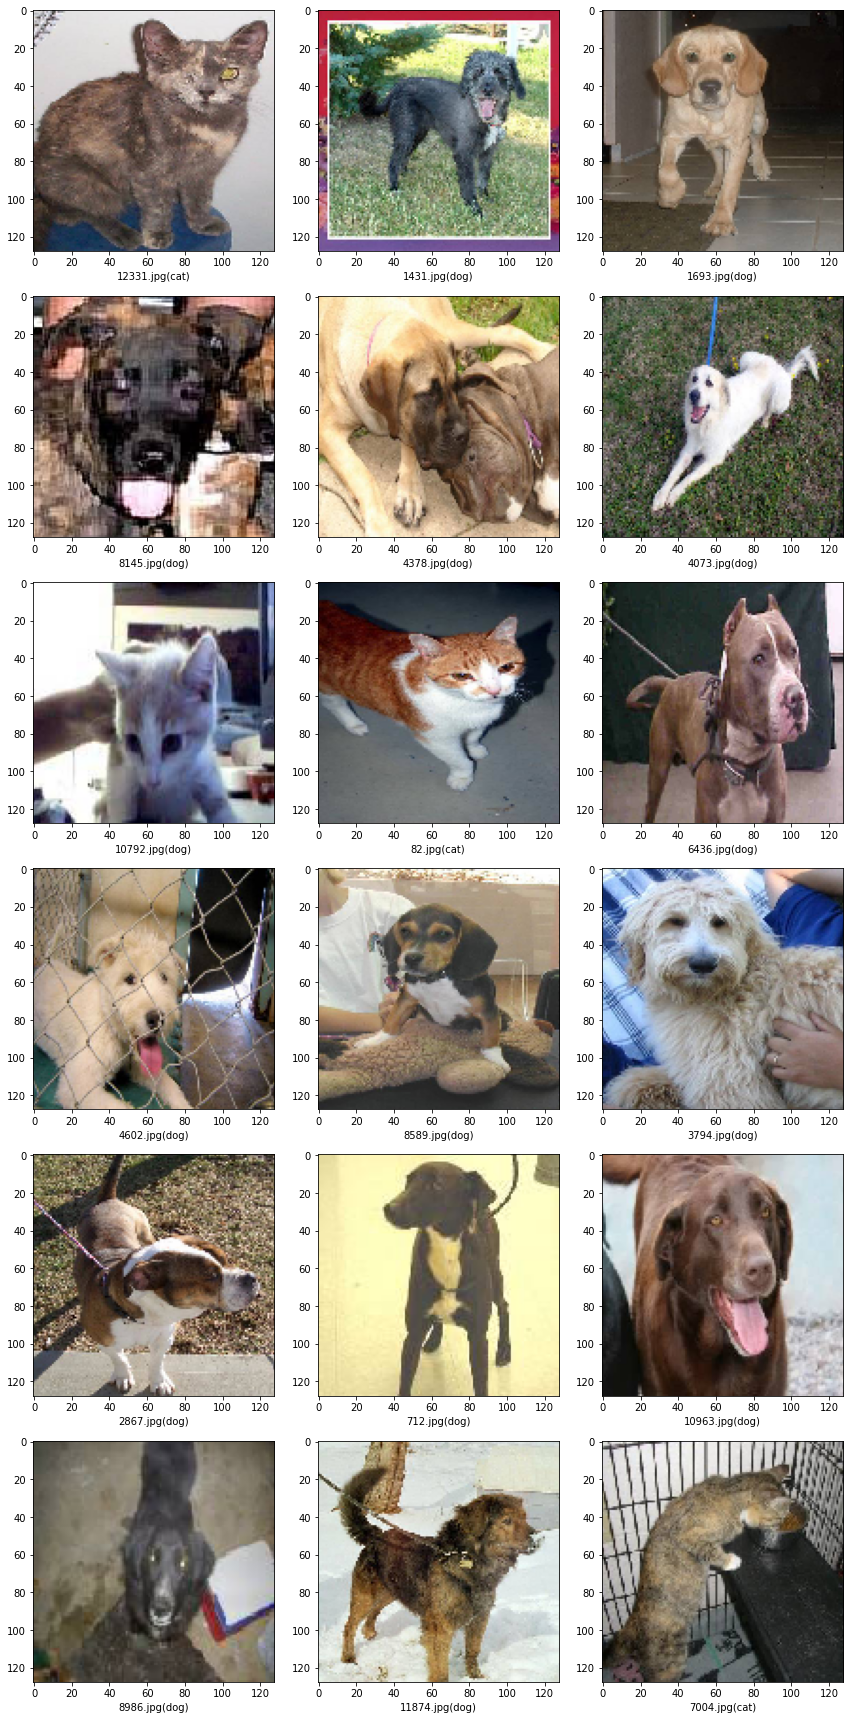

In [ ]:
# 예측 결과
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
  filename = row['filename']
  category = row['category']
  img = load_img('./test1/'+filename, target_size=image_size)
  plt.subplot(6, 3, index+1)
  plt.imshow(img)
  plt.xlabel(filename + '(' + '{}'.format(category) + ')')
  
plt.tight_layout()
plt.show()